## INVESTIGATE THE DATASET

In [1]:
import pandas as pd
from cleaning_functions import fatality
import matplotlib.pyplot as plt


Firs, let's import the clean dataset:

In [2]:
data = pd.read_csv('data_clean.csv')

To begin with, it is a good idea to take a look at the raw numbers:<br> **How many attacks could I classify to have happened during the night and during the day?**

Day      2207
Night     216
Name: night_day, dtype: int64


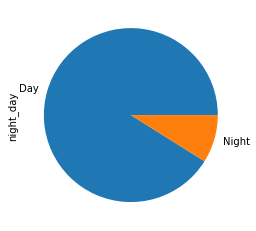

In [3]:
print(data.night_day.value_counts())
data.night_day.value_counts().plot.pie()

Not surprisingly, most of the attacks have happened during the day.There is usually more people in the water during the day that during the night. <br> This same pattern shows up when looking at the total number of fatal accidents during the day and night:

N    1814
Y     393
Name: fatal, dtype: int64
N    167
Y     49
Name: fatal, dtype: int64


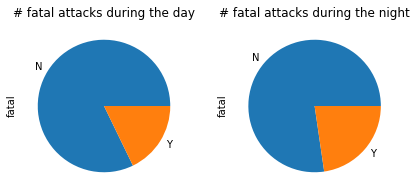

In [4]:
print(data.loc[data.night_day=='Day','fatal'].value_counts())
print(data.loc[data.night_day=='Night','fatal'].value_counts())
plt.subplot(1, 2, 1)
data.loc[data.night_day=='Day','fatal'].value_counts().plot.pie(title='# fatal attacks during the day')
plt.subplot(1,2,2)
data.loc[data.night_day=='Night','fatal'].value_counts().plot.pie(title='# fatal attacks during the night')
plt.tight_layout()

N    1814
Y     393
Name: fatal, dtype: int64
N    167
Y     49
Name: fatal, dtype: int64


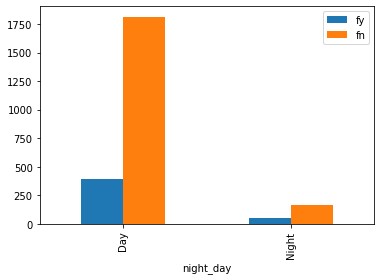

In [5]:
print(data.loc[data.night_day=='Day','fatal'].value_counts())
print(data.loc[data.night_day=='Night','fatal'].value_counts())
data.groupby(['night_day']).agg({'fy':'sum',
                                'fn':'sum'}).plot.bar()

However, these raw numbers are difficult to interpret. One way to meassure the severity of the attacks is checking for the percentage of fatal attacks:

In [6]:
#We use the custom function fatality to calculate % of fatal attacks.
overall_fatality = fatality(data['fatal'])
print(f"The overall fatality is {round(overall_fatality,2)}%")

The overall fatality is 18.24%


night_day
Day      17.806978
Night    22.685185
Name: fatal, dtype: float64


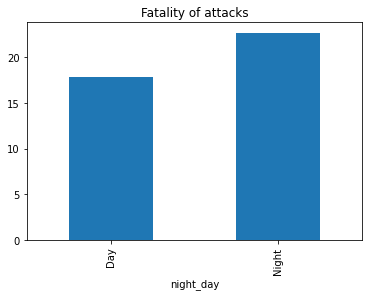

In [7]:
print(data.groupby(['night_day']).fatal.apply(fatality))
data.groupby(['night_day']).fatal.apply(fatality).plot.bar(title='Fatality of attacks')

   activity night_day  fatal
0   fishing       Day    217
1   fishing     Night     26
2     other       Day    115
3     other     Night     16
4  standing       Day    198
5  standing     Night     12
6   surfing       Day    954
7   surfing     Night     94
8  swimming       Day    723
9  swimming     Night     68


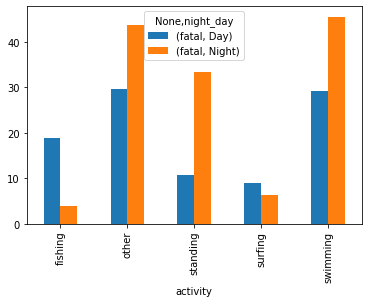

In [83]:
#data.groupby(['activity','night_day']).agg({'fy':lambda x:sum(x)/len(x)*100}).plot.bar()
d = data[['activity','night_day','fatal']].groupby(['activity','night_day']).fatal.agg(fatality).reset_index()

print(data[['activity','night_day','fatal']].groupby(['activity','night_day']).fatal.agg(len).reset_index())

d.pivot_table(values=['fatal'], index=['activity'], columns=['night_day'], aggfunc='first').plot.bar()

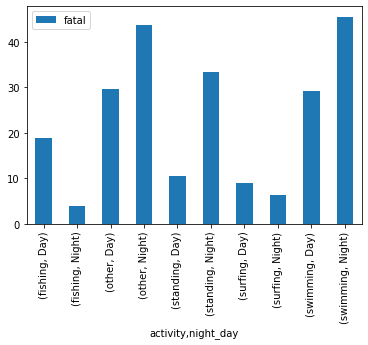

In [16]:
d.plot.bar()